In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy as sp
from scipy import spatial
from scipy import stats

In [3]:
h5 = h5py.File('sound_data_improved.hdf5', 'r')

In [4]:
d = h5['sound_data']

In [5]:
sample_nums = np.random.choice(range(3388858), 10000, replace = False)

In [6]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

In [8]:
pca = sklearnPCA()
fitted = pca.fit(d[index,'feature_vector'])

In [9]:
transformed = pca.fit_transform(d['feature_vector'])

In [7]:
pca_106 = sklearnPCA(106) 
projected = pca_106.fit_transform(d['feature_vector'])

In [8]:
projected_tsne = TSNE(n_components=2).fit_transform(projected[index])

Plot 1: num clusters = 2, silhouette score = 0.51527774, calinski harabasz score = 5488.535919197663, davies bouldin score = 0.6517811813871521
Plot 2: num clusters = 3, silhouette score = 0.20962177, calinski harabasz score = 3839.016732515135, davies bouldin score = 1.8921194743689325
Plot 3: num clusters = 4, silhouette score = 0.20106791, calinski harabasz score = 3699.389632771497, davies bouldin score = 1.6959396801866395
Plot 4: num clusters = 5, silhouette score = 0.17395571, calinski harabasz score = 3144.7088072134493, davies bouldin score = 1.9674272818320528
Plot 5: num clusters = 6, silhouette score = 0.17548364, calinski harabasz score = 2685.862507800825, davies bouldin score = 2.009241621011261
Plot 6: num clusters = 7, silhouette score = 0.1783417, calinski harabasz score = 2449.512626738418, davies bouldin score = 2.017878768421842
Plot 7: num clusters = 8, silhouette score = 0.16039917, calinski harabasz score = 2170.071145621009, davies bouldin score = 2.12440177911

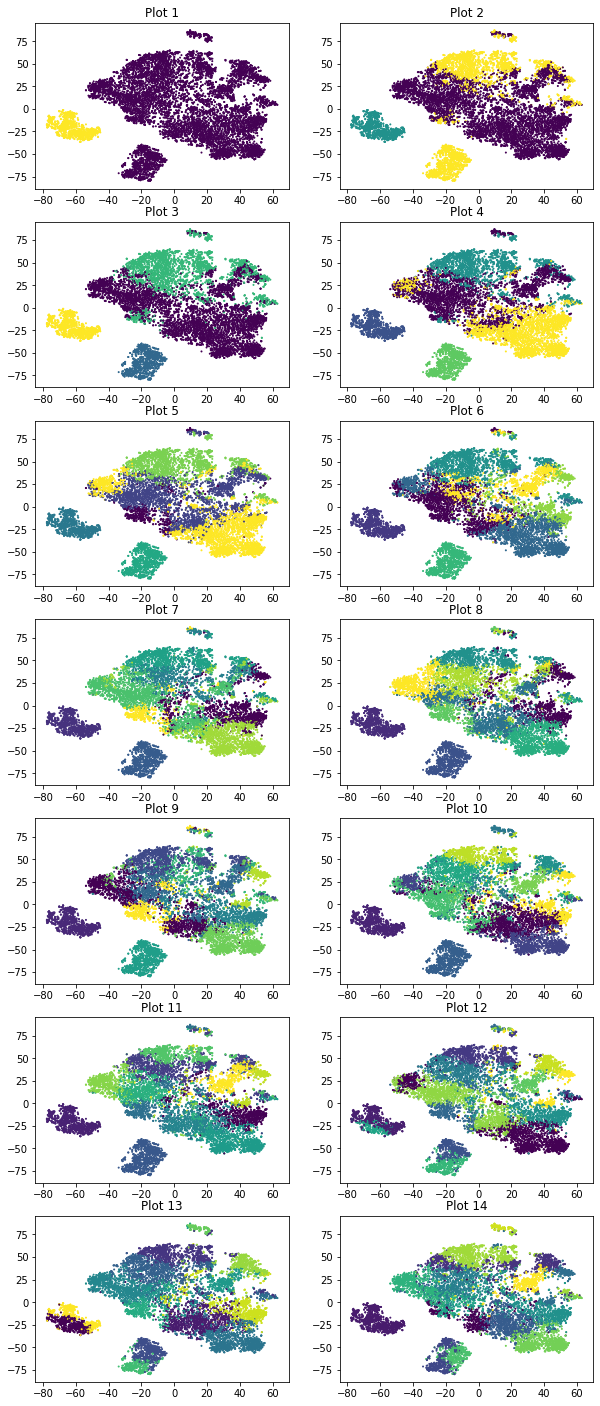

In [9]:
plt.figure(figsize=(10, 25))
idx = 1
for num_clusters in range(2, 16):
    mbk = MiniBatchKMeans(n_clusters=num_clusters, random_state=0)
    mbk_clusters = mbk.fit_predict(projected[index])
    plt.subplot(7, 2, idx)
    plt.scatter(projected_tsne[:, 0], projected_tsne[:, 1], c=mbk_clusters, s = 1)
    plt.title('Plot ' + str(idx))
    silhouette_score = metrics.silhouette_score(projected[index], mbk.labels_, metric='euclidean')
    c_h_score = metrics.calinski_harabasz_score(projected[index], mbk.labels_)
    d_b_score = davies_bouldin_score(projected[index], mbk.labels_) 
    print('Plot ' + str(idx) + ': num clusters = ' + str(num_clusters) + ', silhouette score = ' + str(silhouette_score) \
             + ', calinski harabasz score = ' + str(c_h_score) \
             + ', davies bouldin score = ' + str(d_b_score))
    idx += 1
# plt.tight_layout()
plt.show()

In [10]:
#8 is the best num of clusters
mbk = MiniBatchKMeans(n_clusters=8, random_state=0)
mbk_clusters = mbk.fit_predict(projected[index])
mbk.cluster_centers_

array([[-2.40535307e+00, -1.86403358e+00,  3.62251937e-01,
         2.68536568e+00,  1.71974897e+00, -1.31845474e+00,
         1.52114213e-01, -6.59240246e-01, -1.35724679e-01,
        -4.67456162e-01, -3.62894475e-01,  2.82651149e-02,
        -1.39603794e-01, -5.45147099e-02, -5.49894609e-02,
        -9.29175019e-02, -2.02495679e-02,  6.62996173e-02,
         1.04503833e-01, -6.10419214e-02,  1.39949083e-01,
        -6.25085309e-02,  2.53996402e-02, -8.35481100e-04,
         4.42571752e-02, -5.35461828e-02, -4.76292484e-02,
        -7.35211512e-03,  4.98573370e-02, -2.44647004e-02,
         1.67742511e-03, -6.06177971e-02, -4.26587500e-02,
         4.04495597e-02, -8.23844373e-02,  3.33419666e-02,
        -4.00843099e-02, -4.73266579e-02,  6.41612196e-03,
        -9.05800313e-02,  7.15540051e-02, -5.36557212e-02,
         2.00977195e-02, -4.15972695e-02,  5.10393362e-03,
         3.92625779e-02, -7.43335560e-02,  7.20661227e-03,
         5.95595278e-02,  3.03441063e-02,  5.93810389e-0

In [15]:
mbk.labels_.shape

(10000,)

# Nearest Neighbors and Corresponding Audio Files

In [12]:
tree = spatial.KDTree(projected[index])

In [17]:
nearest_neighbors = tree.query(mbk.cluster_centers_, 5)

In [18]:
mbk.cluster_centers_.shape

(8, 106)

In [23]:
neighbors_arr = []
centroids = []
centroid_num_arr = []
centroid_num = 0
for x in nearest_neighbors[1]:
    for y in x:
        feature_vector = projected[index][y]
        neighbors_idx = stats.mode(np.where(projected==feature_vector)[0])
        #Have to do mode because matches in projected covered almost a whole row, but in some cases shifted a little
        neighbors_arr.append(neighbors_idx.mode[0])
        centroids.append(mbk.cluster_centers_[centroid_num])
        centroid_num_arr.append(centroid_num+1)
    centroid_num += 1

In [63]:
neighbors_arr[4]

991525

In [64]:
neighbors_timestamps_orig = []
neighbors_timestamps = []
neighbors_sensor_id = []
neighbors_file_path = []

In [65]:
for f in neighbors_arr:
    neighbors_timestamps_orig.append(d[f, 'timestamp_orig'])
    neighbors_timestamps.append(d[f, 'timestamp'])
    neighbors_sensor_id.append(d[f, 'sensor_id'])
    neighbors_file_path.append(d[f, 'file_path'])

In [66]:
len(neighbors_arr)

35

In [67]:
neighbors_sensor_id

[b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebe3b72c.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827ebc178d2.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b827eb491436.sonyc',
 b'sonycnode-b

In [68]:
neighbors_file_path[0][32:]

b'sonycnode-b827ebc178d2.sonyc/2019-06-29/06/1561804151.29.npz'

In [69]:
neighbors_file_path_cut = []
for path in neighbors_file_path:
    neighbors_file_path_cut.append(path[32:])

In [70]:
neighbors_timestamps_dt = np.empty(35, dtype = datetime.datetime)
for i in range(35):
    j = neighbors_timestamps[i]
    dt = datetime.datetime.utcfromtimestamp(j)
    dt = pytz.UTC.localize(dt)
    dt = dt.astimezone(pytz.timezone('US/Eastern'))
    neighbors_timestamps_dt[i] = dt

In [71]:
df = pd.DataFrame(centroids)
df.insert(0, "timestamp_orig", neighbors_timestamps_orig, True)
df.insert(1, "timestamp_dt", neighbors_timestamps_dt, True)
df.insert(2, "sensor_id", neighbors_sensor_id, True)
df.insert(3, "file_path", neighbors_file_path_cut, True)
df.insert(4, "centroid_num", centroid_num_arr, True)

In [72]:
df.head()

,timestamp_orig,timestamp_dt,sensor_id,file_path,centroid_num,0,1,2,3,4,...,35,36,37,38,39,40,41,42,43,44
0,1.561804e+09,2019-06-29 06:29:16-04:00,b'sonycnode-b827ebc178d2.sonyc',b'sonycnode-b827ebc178d2.sonyc/2019-06-29/06/1...,1,-2.778697,-2.378556,2.304935,-0.561386,-1.323823,...,0.042156,-0.081429,-0.034606,-0.013001,-0.032552,0.019346,-0.005855,0.011203,0.030197,-0.030237
1,1.561417e+09,2019-06-24 18:48:55-04:00,b'sonycnode-b827ebc178d2.sonyc',b'sonycnode-b827ebc178d2.sonyc/2019-06-24/18/1...,1,-2.778697,-2.378556,2.304935,-0.561386,-1.323823,...,0.042156,-0.081429,-0.034606,-0.013001,-0.032552,0.019346,-0.005855,0.011203,0.030197,-0.030237
2,1.560361e+09,2019-06-12 13:28:54-04:00,b'sonycnode-b827ebc178d2.sonyc',b'sonycnode-b827ebc178d2.sonyc/2019-06-12/13/1...,1,-2.778697,-2.378556,2.304935,-0.561386,-1.323823,...,0.042156,-0.081429,-0.034606,-0.013001,-0.032552,0.019346,-0.005855,0.011203,0.030197,-0.030237
3,1.561640e+09,2019-06-27 09:00:46-04:00,b'sonycnode-b827ebc178d2.sonyc',b'sonycnode-b827ebc178d2.sonyc/2019-06-27/09/1...,1,-2.778697,-2.378556,2.304935,-0.561386,-1.323823,...,0.042156,-0.081429,-0.034606,-0.013001,-0.032552,0.019346,-0.005855,0.011203,0.030197,-0.030237
4,1.561168e+09,2019-06-21 21:38:59-04:00,b'sonycnode-b827ebc178d2.sonyc',b'sonycnode-b827ebc178d2.sonyc/2019-06-21/21/1...,1,-2.778697,-2.378556,2.304935,-0.561386,-1.323823,...,0.042156,-0.081429,-0.034606,-0.013001,-0.032552,0.019346,-0.005855,0.011203,0.030197,-0.030237
